In [291]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression, Lasso, Ridge

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [292]:
og_df = pd.read_csv("datasets/train.csv")
stonebrook_df = pd.read_csv("datasets/train_stonebrook_df.csv")

train_df = pd.read_csv("datasets/final_train_df.csv")
test_df = pd.read_csv("datasets/final_test_df.csv")

In [293]:
#split X,y now that values are in order
X_train = train_df.drop(columns = ['id','pid','saleprice'])
y_train = train_df['saleprice']

X_test = test_df.drop(columns = ['id','pid','saleprice'])
y_test = test_df['saleprice']

In [294]:
#drop feature columns not in test set from train set
droplist = set(X_train.columns) - set(X_test.columns)
X_train = X_train.drop(columns = droplist)

In [295]:
#drop feature columns not in train set in test set
droplist = set(X_test.columns) - set(X_train.columns)
X_test = X_test.drop(columns = droplist)

### Target Variable EDA

<AxesSubplot:xlabel='saleprice', ylabel='Count'>

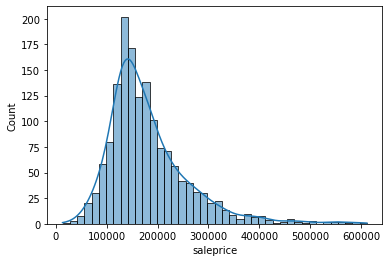

In [296]:
sns.histplot(y_train,kde = True)

### Correlation Heatmap for corr_df

<AxesSubplot:>

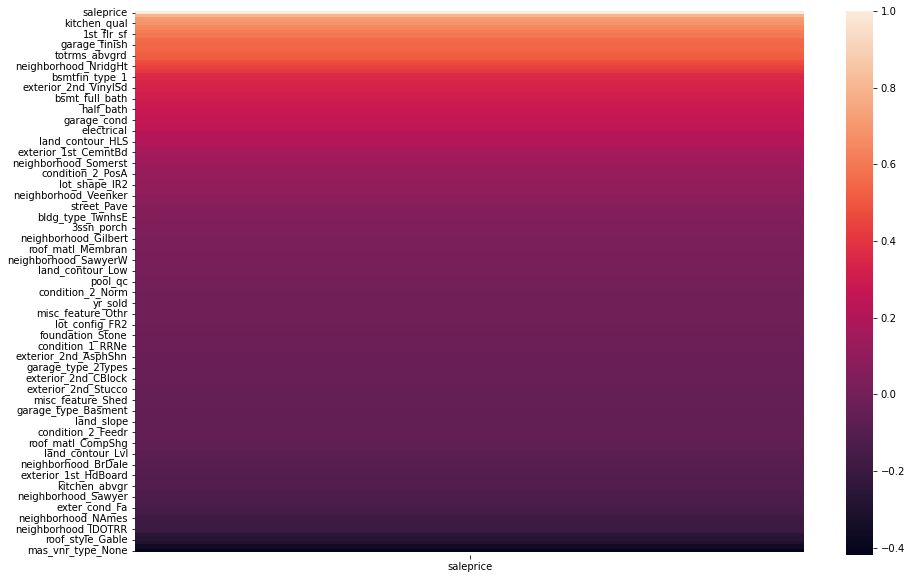

In [297]:
fig, ax = plt.subplots(figsize=(15,10))
sns.heatmap(train_df.corr()[['saleprice']].sort_values(by = 'saleprice',ascending=False))

## Problem at Question:
### What neighborhoods are the best investment?
### What features are correlated with higher prices? 

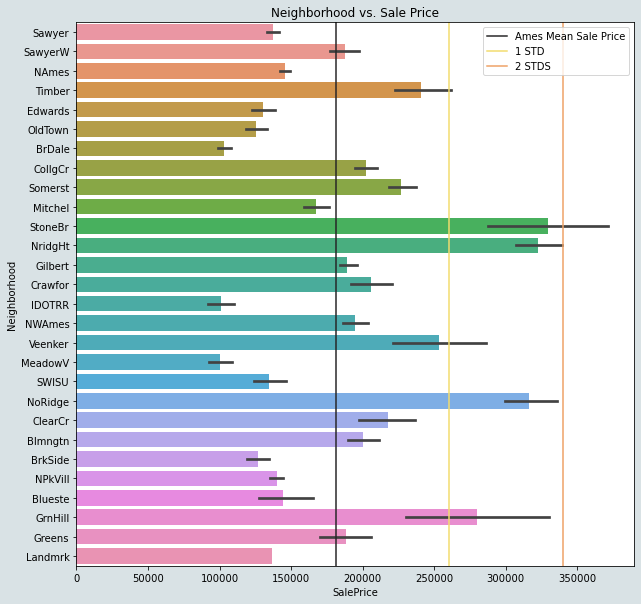

In [298]:
plt.figure(figsize= (10,10),facecolor = '#d9e2e5')
sns.barplot(y = og_df['Neighborhood'],x = og_df['SalePrice'], orient = 'h')
plt.axvline(x =og_df['SalePrice'].mean(),color = '#262526', label = 'Ames Mean Sale Price') #mean
plt.axvline(x =og_df['SalePrice'].mean()+ (og_df['SalePrice'].std()),color = '#f2dc6d', label = '1 STD') #one std
plt.axvline(x =og_df['SalePrice'].mean()+ (2*(og_df['SalePrice'].std())),color = '#efa165', label = '2 STDS') #two stds
plt.title(label = 'Neighborhood vs. Sale Price')
plt.legend()

In [299]:
#find the top 5 neighborhoods with the highest sales price relative to mean of Ames (2 stds away from the mean)
og_df[og_df['SalePrice'] > og_df['SalePrice'].mean() + (2*(og_df['SalePrice'].std()))].sort_values(by='SalePrice',ascending=False)["Neighborhood"].value_counts().head(3)

NridgHt    46
StoneBr    17
NoRidge    12
Name: Neighborhood, dtype: int64

In [300]:
#make own dataframe
top_hood_df = og_df[(og_df['Neighborhood'] == 'NridgHt') | (og_df['Neighborhood'] == 'StoneBr') | (og_df['Neighborhood'] == 'NoRidge')]
top_hood_df

top_neighborhoods = list(top_hood_df['Neighborhood'].unique())

In [301]:
def neigh_mean(neighs):
        x = og_df.loc[(og_df['Neighborhood'] == neighs)]['SalePrice'].mean()
        return round(x,2)

In [302]:
def neigh_describe(neighs):
        x = og_df.loc[(og_df['Neighborhood'] == neighs)]['SalePrice'].describe()
     
        return round(x,2)

neigh_describe('StoneBr')

count        38.00
mean     329675.74
std      128597.74
min      130000.00
25%      218125.00
50%      322450.00
75%      427085.00
max      591587.00
Name: SalePrice, dtype: float64

In [303]:
neigh_describe('NridgHt')

count       122.00
mean     322831.35
std       92964.84
min      154000.00
25%      259279.00
50%      317500.00
75%      379040.50
max      611657.00
Name: SalePrice, dtype: float64

In [304]:
neigh_describe('NoRidge')

count        48.00
mean     316294.12
std       67015.95
min      190000.00
25%      279875.00
50%      300750.00
75%      337750.00
max      584500.00
Name: SalePrice, dtype: float64

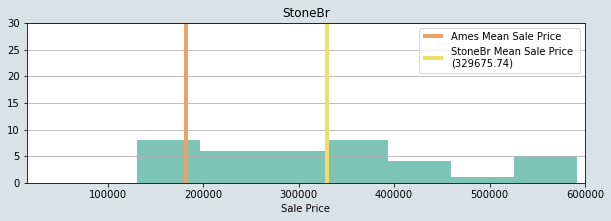

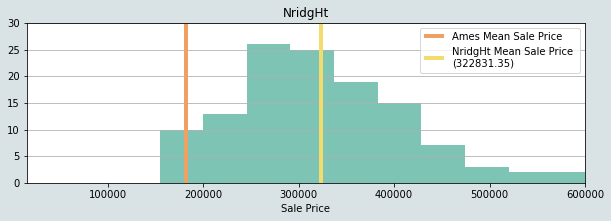

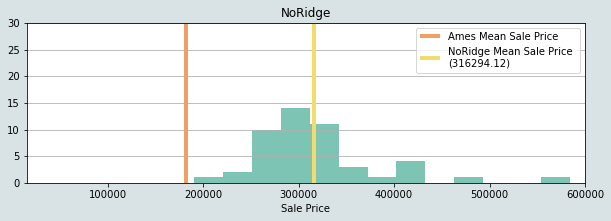

In [305]:
for i,neigh in enumerate(top_neighborhoods):
    plt.figure(figsize=(10,10),facecolor='#d9e2e5')
    ax = plt.subplot(len(top_neighborhoods), 1, i+1)
    plt.hist(og_df.loc[(og_df['Neighborhood'] == neigh)]['SalePrice'],bins='auto',color='#7ec4b4')
    plt.title(neigh)
    plt.xlabel('Sale Price')
    plt.xlim(15000,600000)
    plt.ylim(0,30)
    plt.grid(axis='y')
    plt.vlines(og_df['SalePrice'].mean(),ymin=0,ymax=30,color = '#efa165',label=f'Ames Mean Sale Price',linewidth=4)
    plt.vlines(x = (neigh_mean(neigh)),ymin=0,ymax=30,color = '#f2dc6d',label=f'{neigh} Mean Sale Price \n({(neigh_mean(neigh))})' ,linewidth=4)
    plt.legend()
    

## Percentage of Homes in Stone Brooke below means

In [306]:
#percentage of homes below neighborhood mean
len(og_df[(og_df['Neighborhood'] == 'StoneBr')& (og_df['SalePrice'] <= og_df['SalePrice'].mean())]) / len(og_df[og_df['Neighborhood'] == 'StoneBr'])

0.10526315789473684

In [307]:
#percentage of homes below citywide mean
len(og_df[(og_df['Neighborhood'] == 'StoneBr')& (og_df['SalePrice'] <= neigh_mean('StoneBr'))]) / len(og_df[og_df['Neighborhood'] == 'StoneBr'])

0.5263157894736842

## Stone Brooke DataFrame

In [308]:
stonebrook_df.sort_values(by= 'saleprice')

,id,pid,ms_subclass,lot_frontage,lot_area,overall_qual,overall_cond,year_built,year_remod/add,mas_vnr_area,...,exterior_2nd_MetalSd,exterior_2nd_VinylSd,exterior_2nd_Wd Shng,mas_vnr_type_None,mas_vnr_type_Stone,exter_cond_Gd,exter_cond_TA,garage_type_BuiltIn,sale_type_WD,saleprice
10,1002,527140090,1.175949,-1.246061,-0.755844,-0.810443,-0.267261,-1.600695,-1.629261,-0.998392,...,0,0,0,1,0,0,1,0,1,180000
25,1010,527183060,1.175949,0.058378,-0.708335,-0.810443,-0.267261,-2.273360,-2.288288,-0.998392,...,0,0,0,1,0,0,1,0,1,188500
21,1635,527184110,1.175949,-1.572170,-0.779555,-0.810443,-0.267261,-2.105194,-2.123531,-0.998392,...,0,0,0,1,0,0,1,0,1,212000
11,9,527146030,1.175949,-1.354764,-0.756357,-0.810443,-0.267261,-1.264362,-1.134991,-0.998392,...,0,0,0,1,0,0,1,0,1,236500
8,2328,527190050,2.138090,-1.083006,-0.763462,-2.097618,4.543441,-2.609693,-2.617801,-0.998392,...,0,0,0,1,0,1,0,0,1,239000
0,351,527131030,1.175949,-1.300412,-0.732817,-0.810443,-0.267261,-0.423530,-0.475964,-0.998392,...,0,0,0,1,0,0,1,0,1,278000
22,1000,527127140,1.175949,-1.246061,-0.796247,-0.810443,-0.267261,-0.255364,-0.146450,-0.998392,...,0,0,0,1,0,0,1,0,1,286000
23,1640,527252050,1.175949,-0.159029,-0.529858,0.476731,-0.267261,0.585468,0.512576,-0.475179,...,1,0,0,0,0,0,1,0,1,319900
7,1012,527212050,-0.267261,0.710597,-0.259103,0.476731,-0.267261,0.417302,0.677333,-0.221499,...,0,1,0,0,0,0,1,1,1,325000
15,1015,527252080,1.175949,-0.213380,-0.522753,0.476731,-0.267261,0.753634,0.677333,-0.433956,...,1,0,0,0,0,0,1,0,1,334000


<AxesSubplot:>

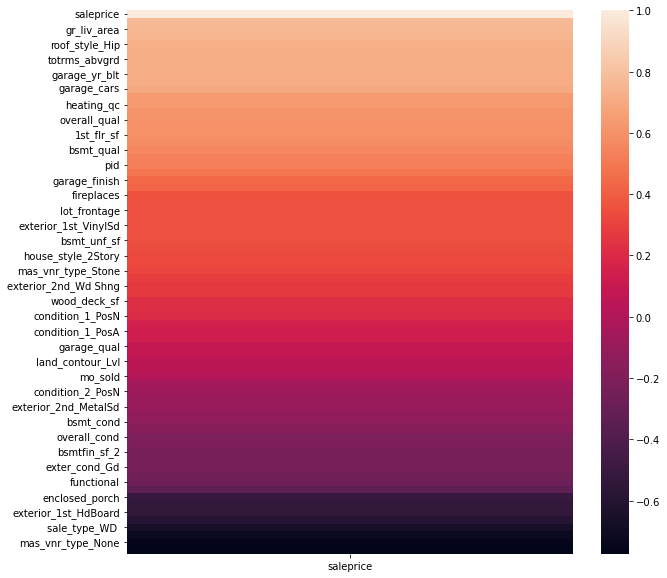

In [309]:
plt.figure(figsize=(10,10))
sns.heatmap(stonebrook_df.corr()[['saleprice']].sort_values(by='saleprice',ascending=False).dropna())

In [310]:
stonebr_corr = stonebrook_df.corr()[['saleprice']].sort_values(by='saleprice',ascending=False).dropna()
stonebr_corr[(stonebr_corr > .5) | (stonebr_corr < -.5)].dropna()

,saleprice
saleprice,1.000000
garage_area,0.768415
gr_liv_area,0.762143
mas_vnr_area,0.747363
roof_style_Hip,0.732200
year_remod/add,0.722612
totrms_abvgrd,0.721313
year_built,0.720354
garage_yr_blt,0.714411
lot_area,0.710716


In [311]:
#list of best and worst features
stonebr_corr_list = stonebr_corr[(stonebr_corr > .7) | (stonebr_corr < -.5)].dropna().index.values

In [312]:
#original plots before feature selection via lasso
# for i,corr in enumerate(stonebr_corr_list):
#     plt.figure(figsize=(5,70),facecolor='#d9e2e5')
#     ax = plt.subplot(len(stonebr_corr_list), 1, i+1)
#     sns.scatterplot(x = stonebrook_df[corr],y = stonebrook_df['saleprice'],color='#7ec4b4')
#     plt.title(f'{corr.capitalize()} vs. Sale Price')
# #     plt.ylabel('Sale Price')

In [313]:
X = stonebrook_df.drop(columns = 'saleprice')
y = stonebrook_df['saleprice']

In [314]:
X_t,X_ts,y_t,y_ts = train_test_split(X,y,test_size=.4,random_state=25)

In [315]:
#not terrible in score but more data overall could help

ridge = Ridge(max_iter=100000)
params = {'alpha':np.logspace(2,5,20)}
grid = GridSearchCV(ridge,params,n_jobs=-1,cv=5)
grid.fit(X_t,y_t)
grid.score(X_t,y_t)
grid.score(X_ts,y_ts)

0.8126644216685608

/var/folders/0_/1fglb9vd35q8v_1ymssrzrxw0000gn/T/ipykernel_28175/1247340568.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,80),facecolor='#d9e2e5')


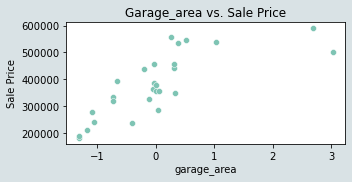

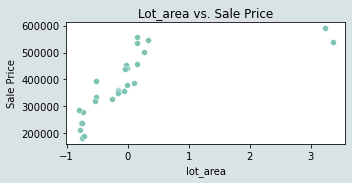

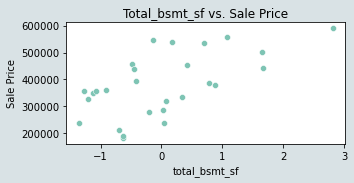

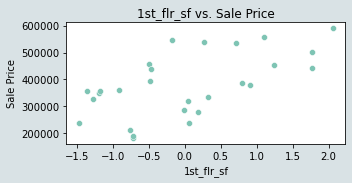

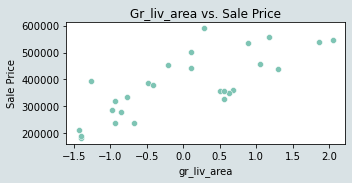

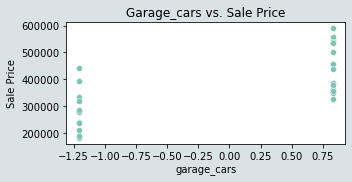

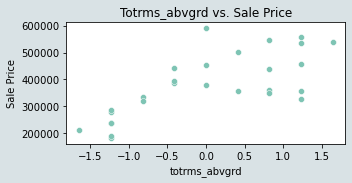

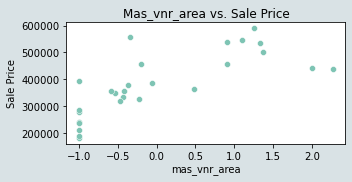

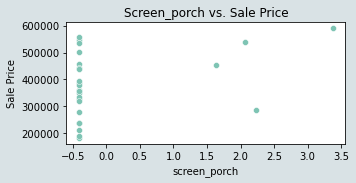

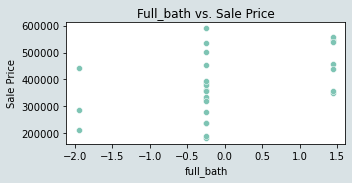

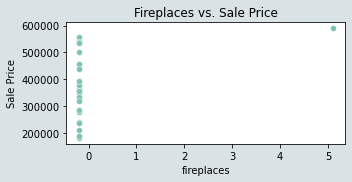

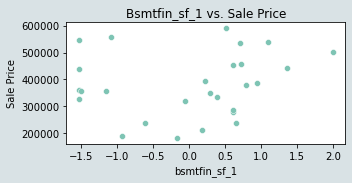

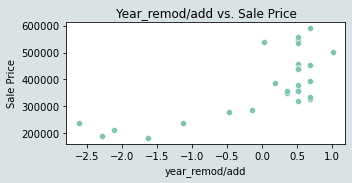

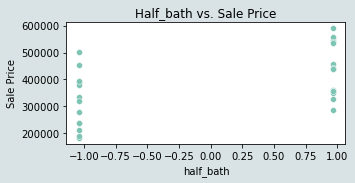

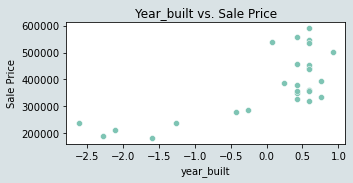

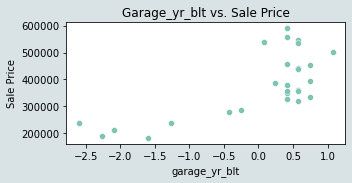

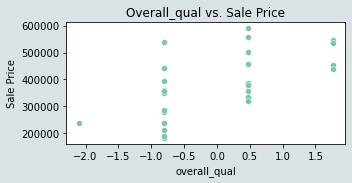

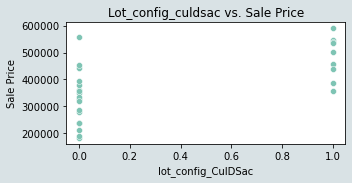

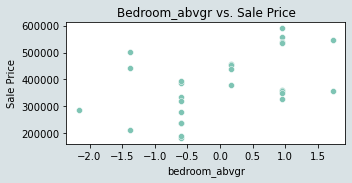

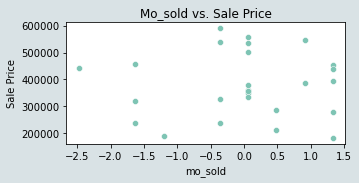

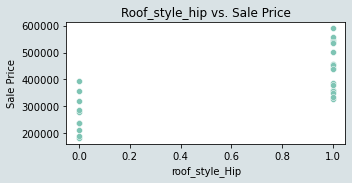

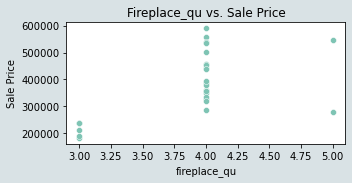

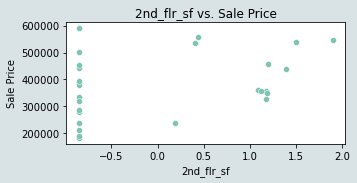

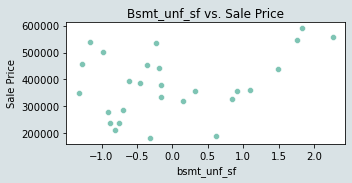

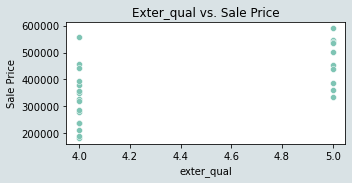

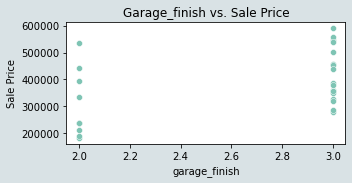

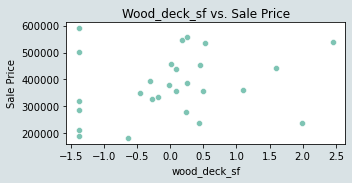

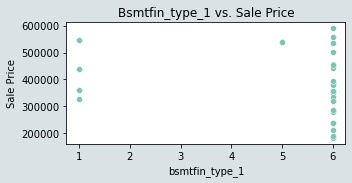

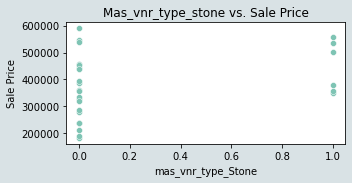

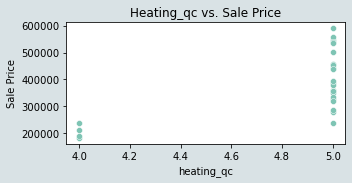

In [316]:
coef_df = pd.DataFrame(grid.best_estimator_.coef_ ,X_t.columns,columns = ['Coef']).sort_values(by='Coef',ascending = False).head(30)
len(coef_df.index.values)
stonebrook_df[coef_df.index.values]
for i,corr in enumerate(coef_df.index.values):
    plt.figure(figsize=(5,80),facecolor='#d9e2e5')
    ax = plt.subplot(len(coef_df.index.values), 1, i+1)
    sns.scatterplot(x = stonebrook_df[corr],y = stonebrook_df['saleprice'],color='#7ec4b4')
    plt.title(f'{corr.capitalize()} vs. Sale Price')
    plt.ylabel('Sale Price')

# Kaggle Datasets and Models

### Best Correlated Variables Dataframe

In [317]:
corr = train_df.corr()[['saleprice']].sort_values(by = 'saleprice',ascending=False)
corr_columns = list(corr[corr > .5].dropna().index)
corr_columns.remove('saleprice')

In [318]:
X_train_corr = train_df[corr_columns]
X_test_corr = test_df[corr_columns]

### VIF Feature DataFrame

In [319]:
#recursive loop to check multicolinearity and remove variables that do not pass the threshold. (5)

def vif_dropper(df):  #input a dataframe
    df_new = df
    
    while True:  #creating a while loop
        
        df_vif = pd.DataFrame()        # create blank dataframe and assigning it to vif_data
        df_vif["feature"] = df_new.columns 
        df_vif["VIF"] = [variance_inflation_factor(df_new.values, i) for i in range(len(df.columns))]

        v = df_vif[df_vif['VIF'] != float('inf')] #filter df for VIF values that  are not inf & saving to new df called v
    
        m = max([i for i in v['VIF']])   # for each of the VIF vals in v df, return the max
        print(m)
        if m < 5:
            break
            
        else:
            feature = df_vif.iloc[df_vif[df_vif['VIF'] == m].index]['feature'].values[0]
            df_new.drop(columns = feature,inplace =True)
            print(feature)
            
    return df_new

In [ ]:
#dropping variables of multicolinearity and saving to new dataframe
X_train_vif = vif_dropper(X_train)

/opt/anaconda3/envs/dsi/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


### Feature Sets

In [ ]:
#best/worst correlated variables dataframe
X_train_corr
X_test_corr

In [ ]:
X_train_vif

#make test columns eqeual to train columns after vif dropper
X_test_vif = X_test[X_train_vif.columns] 
X_test_vif

## Modeling

### Baseline

In [ ]:
y_preds = [y_train.mean() for x in y_test]
mean_squared_error(y_test,y_preds, squared=False)

### Linear Regression

In [ ]:
def linear_fit(X,y,X_test,y_test):
    lr = LinearRegression()
    lr.fit(X,y)
    train = lr.score(X,y)
    test = lr.score(X_test,y_test)
    y_preds = lr.predict(X_test)
    
    return (train,test,mean_squared_error(y_test,y_preds,squared=False))

In [ ]:
# the test set of vif did not at all relate to the linear model. the linear training was too complex and was overfit in this linear regression. 
linear_fit(X_train_vif,y_train,X_test_vif,y_test)

In [ ]:
#the top correlated variables established a better training model
linear_fit(X_train_corr,y_train,X_test_corr,y_test)

### Lasso

In [ ]:
def lasso_fit(X,y,X_test,y_test):
    lasso = Lasso(max_iter=5000)
    params = {'alpha':np.logspace(0,2,20)}
    grid = GridSearchCV(lasso,params,n_jobs=-1,cv=5)
    grid.fit(X,y)
    train = grid.score(X,y)
    test = grid.score(X_test,y_test)
    y_preds = grid.predict(X_test)
    
    return (train,test,mean_squared_error(y_test,y_preds,squared=False))

In [ ]:
#of the two data sets, the vif dataset had a better r score with the lasso model
lasso_fit(X_train_vif,y_train,X_test_vif,y_test)

In [ ]:
lasso_fit(X_train_corr,y_train,X_test_corr,y_test)

### Ridge

In [ ]:
def ridge_fit(X,y,X_test,y_test):
    ridge = Ridge(max_iter=5000)
    params = {'alpha':np.logspace(0,2,20)}
    grid = GridSearchCV(ridge,params,n_jobs=-1,cv=5)
    grid.fit(X,y)
    train = grid.score(X,y)
    test = grid.score(X_test,y_test)
    y_preds = grid.predict(X_test)
    
    return (train,test,mean_squared_error(y_test,y_preds,squared=False))

In [ ]:
#ridge was similar to lasso but not as good. data features and 
#vif dropper were successful at feature selection. could polynomial features inprove. performance?
ridge_fit(X_train_vif,y_train,X_test_vif,y_test)

In [ ]:
ridge_fit(X_train_corr,y_train,X_test_corr,y_test)